### Imports

In [1]:
import numpy as np
import os
import cv2

import torch
from torchvision import transforms
import matplotlib.pyplot as plt

from PIL import Image

c:\Users\Csongi\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Csongi\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


### Create Dataset

In [2]:
data_src_folder = "C:\\BME\\7_felev\\szakdoli\\dataset\\FER2013Plus\\numpy_data"

train_images = np.load(os.path.join(data_src_folder, 'train_images.npy'))
train_labels = np.load(os.path.join(data_src_folder, 'train_labels.npy'))

val_images = np.load(os.path.join(data_src_folder, 'val_images.npy'))
val_labels = np.load(os.path.join(data_src_folder, 'val_labels.npy'))

test_images = np.load(os.path.join(data_src_folder, 'test_images.npy'))
test_labels = np.load(os.path.join(data_src_folder, 'test_labels.npy'))

print(f"train_images shape: {train_images.shape}, train_labels shape: {train_labels.shape}")
print(f"train_images shape: {val_images.shape}, train_labels shape: {val_labels.shape}")
print(f"train_images shape: {test_images.shape}, train_labels shape: {test_labels.shape}")

train_images shape: (28389, 48, 48), train_labels shape: (28389, 8)
train_images shape: (3546, 48, 48), train_labels shape: (3546, 8)
train_images shape: (3553, 48, 48), train_labels shape: (3553, 8)


In [3]:
from torch.utils.data import Dataset, DataLoader
class FERP_PreDataset(Dataset):
  def __init__(self, x_face, y_lab, transform):
    super(FERP_PreDataset,self).__init__()
    self.x_face = x_face
    self.y_lab = y_lab
    self.transform = transform 

  def __len__(self):
    return len(self.y_lab)
  
  def __getitem__(self, index):
    image_face = self.x_face[index]
    label = self.y_lab[index]
    
    image_face = np.array(image_face, dtype=np.uint8)
    image_face = cv2.cvtColor(image_face, cv2.COLOR_GRAY2RGB)

    return self.transform(image_face), torch.tensor(label, dtype=torch.float32)

In [4]:
batch_size = 32

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
])
test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.Resize((224, 224))])

train_dataset = FERP_PreDataset(train_images, train_labels, \
                                  train_transform)
val_dataset = FERP_PreDataset(val_images, val_labels, \
                                test_transform)
test_dataset = FERP_PreDataset(test_images, test_labels, \
                                 test_transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False) 

print ('train loader ', len(train_loader), 'val loader ', len(val_loader), 'test', len(test_loader))

train loader  887 val loader  111 test 112


### MediaPipe setup

In [5]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

model_path_local = 'C:\\BME\\7_felev\\szakdoli\\models\\mediapipe\\face_landmarker_v2_with_blendshapes.task'

base_options = python.BaseOptions(model_asset_path=model_path_local)
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                        output_face_blendshapes=True,
                                        output_facial_transformation_matrixes=True,
                                        num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

In [6]:
# Visualization code by google
#@markdown We implemented some functions to visualize the face landmark detection results. <br/> Run the following cell to activate the functions.

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import drawing_utils_copy


def draw_landmarks_on_image(rgb_image, detection_result, ):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks
    ])

    drawing_utils_copy.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_TESSELATION,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_tesselation_style())
    drawing_utils_copy.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_CONTOURS,
        landmark_drawing_spec=None,
        connection_drawing_spec=mp.solutions.drawing_styles
        .get_default_face_mesh_contours_style())
    drawing_utils_copy.draw_landmarks(
        image=annotated_image,
        landmark_list=face_landmarks_proto,
        connections=mp.solutions.face_mesh.FACEMESH_IRISES,
          landmark_drawing_spec=None,
          connection_drawing_spec=mp.solutions.drawing_styles
          .get_default_face_mesh_iris_connections_style())

  return annotated_image

def plot_face_blendshapes_bar_graph(face_blendshapes):
  # Extract the face blendshapes category names and scores.
  face_blendshapes_names = [face_blendshapes_category.category_name for face_blendshapes_category in face_blendshapes]
  face_blendshapes_scores = [face_blendshapes_category.score for face_blendshapes_category in face_blendshapes]
  # The blendshapes are ordered in decreasing score value.
  face_blendshapes_ranks = range(len(face_blendshapes_names))

  fig, ax = plt.subplots(figsize=(12, 12))
  bar = ax.barh(face_blendshapes_ranks, face_blendshapes_scores, label=[str(x) for x in face_blendshapes_ranks])
  ax.set_yticks(face_blendshapes_ranks, face_blendshapes_names)
  ax.invert_yaxis()

  # Label each bar with values
  for score, patch in zip(face_blendshapes_scores, bar.patches):
    plt.text(patch.get_x() + patch.get_width(), patch.get_y(), f"{score:.4f}", va="top")

  ax.set_xlabel('Score')
  ax.set_title("Face Blendshapes")
  plt.tight_layout()
  plt.show()

In [7]:
data_src_folder = "C:\\BME\\7_felev\\szakdoli\\dataset\\FER2013Plus\\numpy_data"

average_2d_mask = np.load(os.path.join(data_src_folder, "average_mask.npy"))

tensor([0., 0., 0., 0., 0., 0., 1., 0.])
(224, 224, 3)
478


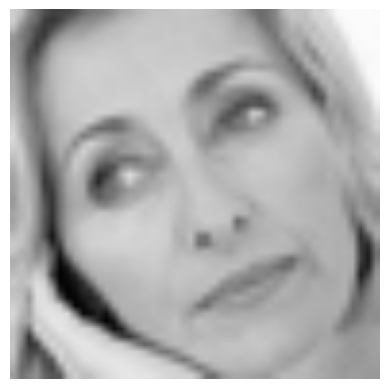

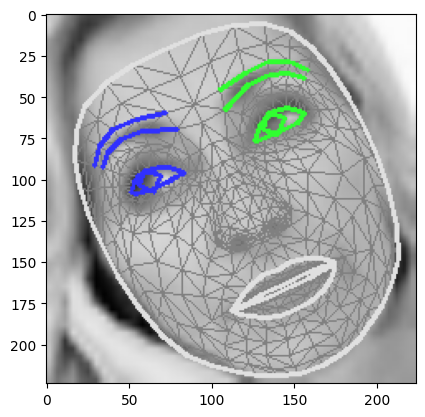

In [ ]:
i = 43
image, label = test_dataset[i]
print(label)

image = np.array(image, dtype=np.uint8)
print(image.shape)

mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)
detection_result = detector.detect(mp_image)
annotated_image = draw_landmarks_on_image(mp_image.numpy_view(), detection_result)

print(len(detection_result.face_landmarks[0]))

plt.axis('off')
plt.imshow(image)
plt.show()

plt.imshow(annotated_image)
plt.show()
# plt.imshow(image)
# plt.show()

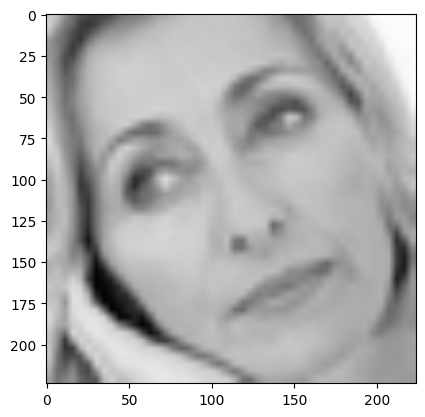

In [24]:
plt.imshow(image)
plt.show()

In [10]:
# normalizer code from mediapipe

from typing import List, Mapping, Optional, Tuple, Union
import math

def _normalized_to_pixel_coordinates(
    normalized_x: float, normalized_y: float, image_width: int,
    image_height: int) -> Union[None, Tuple[int, int]]:
  """Converts normalized value pair to pixel coordinates."""

  # Checks if the float value is between 0 and 1.
  def is_valid_normalized_value(value: float) -> bool:
    return (value > 0 or math.isclose(0, value)) and (value < 1 or
                                                      math.isclose(1, value))

  if not (is_valid_normalized_value(normalized_x) and
          is_valid_normalized_value(normalized_y)):
    # TODO: Draw coordinates even if it's outside of the image bounds.
    return None
  x_px = min(math.floor(normalized_x * image_width), image_width - 1)
  y_px = min(math.floor(normalized_y * image_height), image_height - 1)
  return x_px, y_px

69 90
4
103 19
151


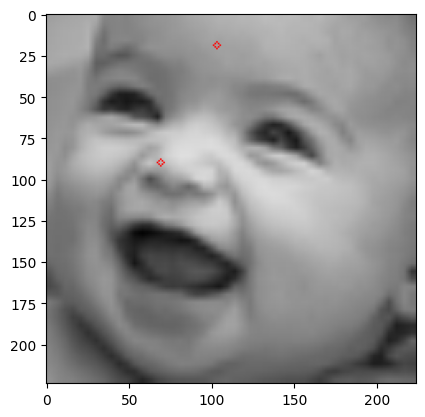

In [11]:
# plotting nose and middle of forehead points for a given image which has run through mediapipe

image_width = 224
image_height = 224

image = np.array(image, dtype=np.uint8)

i = 0
for landmark in detection_result.face_landmarks[0]:
    px_coords = _normalized_to_pixel_coordinates(landmark.x, landmark.y, image_width, image_height)
    
    if px_coords is not None:
        x, y = px_coords
        if i == 151:
            print(x, y)
            print(i)
            cv2.circle(image, (x, y), 2, (0, 0, 255), 1)
        if i == 4:
            print(x, y)
            print(i)
            cv2.circle(image, (x, y), 2, (0, 0, 255), 1)
            
    i += 1
        
image_rgb_with_circle = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.imshow(image_rgb_with_circle)
plt.show()

In [25]:
def get_detection_result_for_image(image, detector):
    image = np.array(image, dtype=np.uint8)
    
    image = mp.Image(image_format = mp.ImageFormat.SRGB, data = image)
    detection_result = detector.detect(image)
    
    return detection_result

In [26]:
def calculate_transformation_values_for_image(detection_result, image_width, image_height):
    nose_3d = detection_result.face_landmarks[0][4]
    forehead_3d = detection_result.face_landmarks[0][151]
    random_3d = detection_result.face_landmarks[0][356]
    
    nose = _normalized_to_pixel_coordinates(nose_3d.x, nose_3d.y, image_width, image_height)
    forehead = _normalized_to_pixel_coordinates(forehead_3d.x, forehead_3d.y, image_width, image_height)
    random = _normalized_to_pixel_coordinates(random_3d.x, random_3d.y, image_width, image_height)
    if nose != None and forehead != None:
        nose_x, nose_y = nose
        forehead_x, forehead_y = forehead
        nose_2d = np.array([nose_x, nose_y])
        forehead_2d = np.array([forehead_x, forehead_y])
        center = np.array([int(image_height / 2), int(image_width / 2)])
        
        translation = center - nose_2d
        
        rotation_multiplier = -1
        if (forehead_2d - nose_2d)[0] > 0: rotation_multiplier = 1
        
        distance_nose_forehead = np.linalg.norm(nose_2d - forehead_2d)
        translated_forehead_2d = forehead_2d + translation
        rotated_forehead_2d = center + np.array([0, -distance_nose_forehead])
        
        scaling_factor = 90 / distance_nose_forehead
        
        b = np.linalg.norm(translated_forehead_2d - rotated_forehead_2d) / 2
        c = distance_nose_forehead
        
        rotation_angle = math.degrees(2 * math.asin(b / c))
        
        return translation, rotation_angle * rotation_multiplier, scaling_factor
    else:
        return None
    

In [27]:
translation, rotation_angle, scaling_factor = calculate_transformation_values_for_image(detection_result, 224, 224)
print(f"translation: {translation}, rotation: {rotation_angle} scaling factor: {scaling_factor}")

translation: [-11 -10], rotation: -26.56505117707799 scaling factor: 0.9583148474999099


In [28]:
def translate_image(image, translation):
    translation_matrix = np.float32([[1, 0, translation[0]], [0, 1, translation[1]]])
    translated_image = cv2.warpAffine(image, translation_matrix, (image.shape[1], image.shape[0]))
    return translated_image

In [ ]:
def rotate_image(image, center, angle):
    center = (int(center[1]), int(center[0]))
    rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (image.shape[1], image.shape[0]))
    return rotated_image

In [ ]:
def zoom_image(image, zoom_factor, target_size=(224, 224)):
    center_x, center_y = image.shape[1] // 2, image.shape[0] // 2

    if zoom_factor > 1:
        crop_width = int(image.shape[1] / zoom_factor)
        crop_height = int(image.shape[0] / zoom_factor)

        x1 = center_x - crop_width // 2
        x2 = center_x + crop_width // 2
        y1 = center_y - crop_height // 2
        y2 = center_y + crop_height // 2

        x1, x2 = max(0, x1), min(image.shape[1], x2)
        y1, y2 = max(0, y1), min(image.shape[0], y2)

        cropped_image = image[y1:y2, x1:x2]

        zoomed_image = cv2.resize(cropped_image, target_size, interpolation=cv2.INTER_LINEAR)
    elif zoom_factor == 1:
        zoomed_image = image
    else:  # zoom_factor < 1
        new_width = int(image.shape[1] / zoom_factor)
        new_height = int(image.shape[0] / zoom_factor)

        padded_image = np.zeros((new_height, new_width, 3), dtype=image.dtype)

        start_x = (new_width - image.shape[1]) // 2
        start_y = (new_height - image.shape[0]) // 2

        padded_image[start_y:start_y + image.shape[0], start_x:start_x + image.shape[1]] = image

        zoomed_image = cv2.resize(padded_image, (target_size[1], target_size[0]))

        
    return zoomed_image

[-11 -10]
-26.56505117707799
0.9583148474999099
(224, 224, 3)


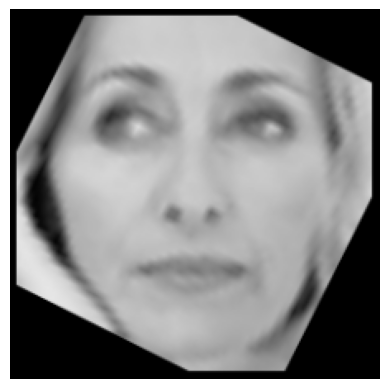

In [31]:
# Transformation for one image

translation, rotation_angle, zoom_factor = calculate_transformation_values_for_image(detection_result, image.shape[1], image.shape[0])

print(translation)
print(rotation_angle)
print(zoom_factor)

# translation = [14, -14]
# rotation_angle = -2.9532275375170323
# zoom_factor = 0.9019929984915814

translated_image = translate_image(image, translation)

center = np.array([int(image.shape[0] / 2), int(image.shape[1] / 2)])
rotated_image = rotate_image(translated_image, center, rotation_angle)

print(rotated_image.shape)

final_image = zoom_image(rotated_image, zoom_factor)

plt.axis('off')
plt.imshow(final_image)
plt.show()

In [21]:
def convert_3d_2_2d(face_landmarks, image_width, image_height):
    _2d_coords = []
    for landmark in face_landmarks:
        px_coords = _normalized_to_pixel_coordinates(landmark.x, landmark.y, image_width, image_height)
        
        if px_coords != None:
            x, y = px_coords
            _2d_coords.append([x, y])
        else:
            _2d_coords.append([0, 0])
            
    return np.array(_2d_coords)

In [22]:
def calculate_transformation_matrix(detection_result, image_width, image_height, average_mesh):
    face_mesh = convert_3d_2_2d(detection_result.face_landmarks[0], image_width, image_height)

    src_points = face_mesh
    dst_points = average_mesh
    
    matrix, inliers = cv2.estimateAffine2D(src_points, dst_points)
    
    # plt.scatter(*(src_points @ matrix[:, :2].T + matrix[:, 2]).T)
    # plt.scatter(*dst_points.T)
    # plt.show()
    
    return matrix

In [28]:
final_images = []
final_indices = []

data_src_folder = "C:\\BME\\7_felev\\szakdoli\\dataset\\FER2013Plus\\numpy_data"
average_mesh = np.load(os.path.join(data_src_folder, "average_mask.npy"))

for i in range(len(test_dataset)):
    if i % 500 == 0: print(i)
    test_image, test_label = test_dataset[i]
    detection_result = get_detection_result_for_image(test_image, detector)
    if len(detection_result.face_landmarks) > 0:
        transformation_matrix = calculate_transformation_matrix(detection_result, test_image.width, test_image.height, average_mesh)
        if True:
            test_image = np.array(test_image)
            
            final_image = cv2.warpAffine(test_image, transformation_matrix, (224, 224))
        
            final_images.append(final_image)
            final_indices.append(i)

0
500
1000
1500
2000
2500
3000
3500


In [29]:
print(len(final_images))
print(len(final_indices))
print(len(test_images))

3154
3154
3553


In [30]:
final_test_images = []
final_test_labels = []

for i in final_indices:
    final_test_images.append(test_images[i])
    final_test_labels.append(test_labels[i])

In [31]:
traf = np.array(final_images)
normal = np.array(final_test_images)
normal_label = np.array(final_test_labels)

In [32]:
print("Shape of traf:", traf.shape)
print("Shape of normal:", normal.shape)
print("Shape of normal_label:", normal_label.shape)

Shape of traf: (3154, 224, 224, 3)
Shape of normal: (3154, 48, 48)
Shape of normal_label: (3154, 8)


In [33]:
data_src_folder = "C:\\BME\\7_felev\\szakdoli\\dataset\\FER2013Plus\\numpy_data"

np.save(os.path.join(data_src_folder, 'matrix_transformed_test.npy'), traf)
np.save(os.path.join(data_src_folder, 'matrix_normal_test.npy'), normal)
np.save(os.path.join(data_src_folder, 'matrix_normal_test_label.npy'), normal_label)

In [117]:
def translate_points(points, translation):
    translated_points = points + translation
    return translated_points

def rotate_points(points, center, angle):
    angle_rad = np.radians(angle)
    
    rotation_matrix = np.array([[np.cos(angle_rad), -np.sin(angle_rad)],
                                 [np.sin(angle_rad), np.cos(angle_rad)]])
    
    centered_points = points - center
    
    rotated_points = centered_points.dot(rotation_matrix.T)
    
    rotated_points += center
    
    return rotated_points

def zoom_points(points, zoom_factor, center):
    if zoom_factor != 1:
        scaled_points = (points - center) * zoom_factor + center
        return scaled_points
    return points


print(translation)
print(rotation_angle)
print(scaling_factor)

[-18 -20]
2.950779109006351
0.9266048594809643


In [118]:
points = np.array([[130, 132], [135, 35], [198, 84]])

translated_points = translate_points(points, translation)
rotated_points = rotate_points(translated_points, [112, 112], -rotation_angle)
zoomed_points = zoom_points(rotated_points, scaling_factor, [112, 112]) 

# print("Translated Points:\n", translated_points)
# print("Rotated Points:\n", rotated_points)
print("Zoomed Points:\n", zoomed_points)

Zoomed Points:
 [[112.         112.        ]
 [112.          22.        ]
 [172.63599746  64.33835065]]


In [ ]:
import numpy as np

moving_landmarks = np.array([[50, 50], [60, 50], [60, 60]])

theta = 30
theta_rad = np.radians(theta)

R = np.array([[np.cos(theta_rad), -np.sin(theta_rad)],
              [np.sin(theta_rad), np.cos(theta_rad)]])

rotated_landmarks = np.dot(moving_landmarks - np.array([55, 55]), R) + np.array([55, 55])

print(rotated_landmarks)


[[48.16987298 53.16987298]
 [56.83012702 48.16987298]
 [61.83012702 56.83012702]]
